In [ ]:
from src.dataset import EvalTripletDataset
from src.eval import *
from src.head import EmbeddingHead
import torch
from torchvision.models import convnext_tiny
from torch.utils.data import DataLoader

In [ ]:
checkpoint_path = r'weights\conv1_head_experiment5.pth'
img1_path = r'val_data\part9\P6002380446\61080570857930905_155661509.png'
img2_path = r'val_data\part9\P6002380446\R3370198225\2198292558.jpg'
valid_data_path = r""
device = 'cuda' if torch.cuda.is_available() else 'cpu'
parallel = False

In [ ]:
model = convnext_tiny()
model.classifier = EmbeddingHead(128, 768)
model.to(device)

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize tất cả ảnh về 224x224
        transforms.ToTensor(),  # Chuyển ảnh thành tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
print(f"Load model weight from checkpoint: {checkpoint_path} !")
checkpoint = torch.load(checkpoint_path, map_location=device)
# Xóa tiền tố 'module.' nếu checkpoint được train với DataParallel
if parallel:
    new_state_dict = checkpoint["model_state_dict"]
else:
    new_state_dict = {k.replace("module.", ""): v for k, v in checkpoint["model_state_dict"].items()}
model.load_state_dict(new_state_dict)

Load model weight from checkpoint: weights\conv1_head_experiment5.pth !


<All keys matched successfully>

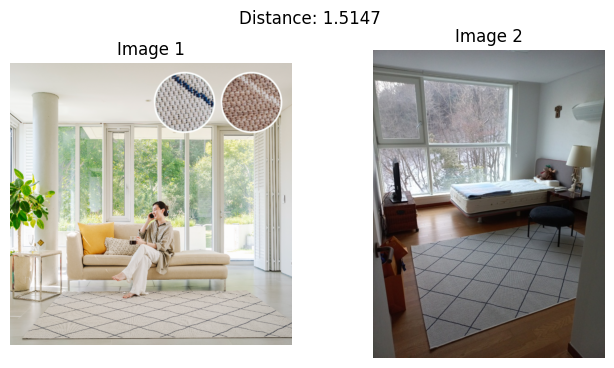

Distance: 1.5147
0


In [ ]:
is_same = test_image_embedding_model(img1_path, img2_path, model, 1)

if is_same == 1:
    print("This is review of product!")
else:
    print("This is not review of product! ")

In [ ]:
test_dataset = EvalTripletDataset(valid_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import numpy as np
from tqdm import tqdm

def find_best_threshold(model, loader, n_samples=500):
    model.eval()
    thresholds = np.arange(0.75, 2.05, 0.05)
    best_threshold = 1.0
    best_f1 = -1.0

    results_by_threshold = {th: {"tp": 0, "tn": 0, "fp": 0, "fn": 0} for th in thresholds}
    processed_samples = 0

    with torch.no_grad():
        for step, (anchor, positive, negative) in enumerate(tqdm(loader desc="Finding Best Threshold")):
            anchor, positive, negative = (
                anchor.to(device),
                positive.to(device),
                negative.to(device),
            )

            anchor_embed = model(anchor)
            pos_embed = model(positive)
            neg_embed = model(negative)

            for th in thresholds:
                tp, tn, fp, fn = evaluate_batch(anchor_embed, pos_embed, neg_embed, threshold=th)
                results_by_threshold[th]["tp"] += tp
                results_by_threshold[th]["tn"] += tn
                results_by_threshold[th]["fp"] += fp
                results_by_threshold[th]["fn"] += fn

            processed_samples += anchor.size(0)
            if processed_samples >= n_samples:
                break

    # Evaluate F1-score for each threshold
    for th in thresholds:
        res = results_by_threshold[th]
        tp, tn, fp, fn = res["tp"], res["tn"], res["fp"], res["fn"]
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = th

    print(f"Best Threshold: {best_threshold:.2f} with F1-score: {best_f1:.4f}")
    return best_threshold


best_th = find_best_threshold(model, test_loader)